In [ ]:
# https://github.com/Leta1603/ML04/blob/main/homework%2027/homework.ipynb - хорошие результаты

In [ ]:
from google.colab import files

uploaded = files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
!unzip archive.zip -d extracted_folder

Archive:  archive.zip
  inflating: extracted_folder/forex.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense

In [ ]:
# Загружаем данные
currency_ts = pd.read_csv('extracted_folder/forex.csv')
currency_ts["date"] = pd.to_datetime(currency_ts["date"])
currency_ts = currency_ts.set_index("date").sort_index()

In [ ]:
# Фильтруем только JPY/USD
jpy_usd = currency_ts[currency_ts["slug"] == "JPY/USD"].drop(columns=["currency", "slug"])

In [ ]:
# Проверка стационарности
result = adfuller(jpy_usd["close"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.7961449414410917
p-value: 0.38237729592201913


In [ ]:
# Разности
close_diff = jpy_usd["close"].diff().dropna()
result = adfuller(close_diff)
print("ADF Statistic (diff):", result[0])
print("p-value (diff):", result[1])

ADF Statistic (diff): -13.34353244713784
p-value (diff): 5.855730023883032e-25


In [ ]:
# Train/Test для ARIMA
split_point = int(len(jpy_usd["close"]) * 0.8)
train, test = jpy_usd["close"][:split_point], jpy_usd["close"][split_point:]

In [ ]:
# Авто-ARIMA
auto_model = auto_arima(train, seasonal=False, stepwise=True)
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5132
Model:               SARIMAX(0, 1, 1)   Log Likelihood               41446.056
Date:                Mon, 08 Dec 2025   AIC                         -82888.112
Time:                        13:20:13   BIC                         -82875.026
Sample:                             0   HQIC                        -82883.532
                               - 5132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1689   1.15e-19  -1.47e+18      0.000      -0.169      -0.169
sigma2      5.486e-09   1.84e-11    297.511      0.000    5.45e-09    5.52e-09
Ljung-Box (L1) (Q):                   0.05   Jarque-

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA
MAE: 0.0007903406016520207
RMSE: 0.000833375126416153


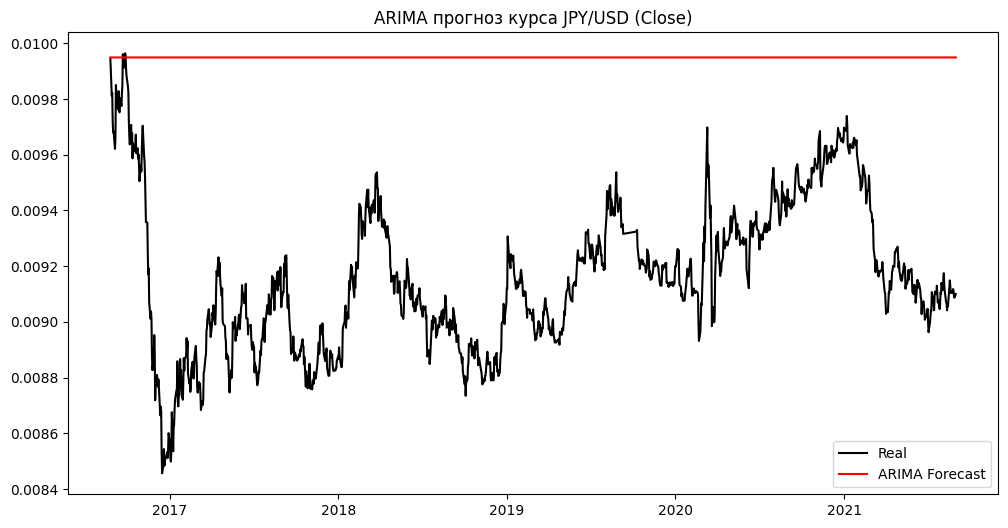

In [ ]:
# ARIMA
model_arima = ARIMA(train, order=(0,1,1))
arima_fit = model_arima.fit()
arima_pred = arima_fit.predict(start=len(train), end=len(train)+len(test)-1)

print("ARIMA")
print("MAE:", mean_absolute_error(test, arima_pred))
print("RMSE:", np.sqrt(mean_squared_error(test, arima_pred)))

plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Real", color="black")
plt.plot(test.index, arima_pred, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("ARIMA прогноз курса JPY/USD (Close)")
plt.show()

In [ ]:
# Подготовка данных для LSTM/GRU
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(close_diff.values.reshape(-1,1))

def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled, seq_length)

split_point = int(len(X) * 0.8)
X_train, y_train = X[:split_point], y[:split_point]
X_test, y_test = X[split_point:], y[split_point:]

# Восстановим y_test в исходный масштаб
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
GRU
MAE: 3.2149629803933736e-05
RMSE: 4.37079070119611e-05


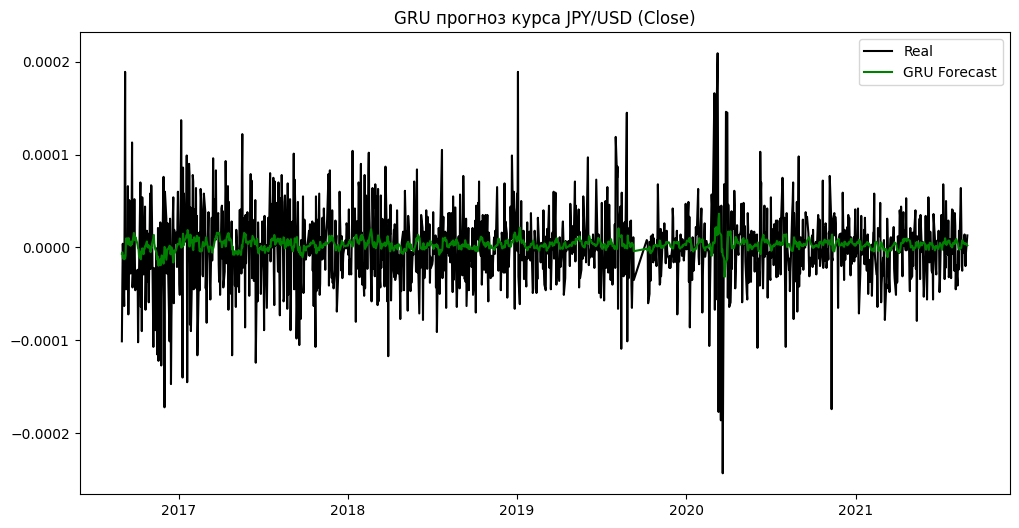

In [ ]:
# GRU
model_gru = Sequential([
    GRU(50, activation="relu", input_shape=(seq_length,1)),
    Dense(1)
])
model_gru.compile(optimizer="adam", loss="mse")
model_gru.fit(X_train, y_train, epochs=20, verbose=0)

gru_pred = model_gru.predict(X_test)
gru_pred = scaler.inverse_transform(gru_pred)

print("GRU")
print("MAE:", mean_absolute_error(y_test_inv, gru_pred))

rmse = np.sqrt(mean_squared_error(y_test_inv, gru_pred))
print("RMSE:", rmse)

plt.figure(figsize=(12,6))
plt.plot(close_diff.index[-len(y_test_inv):], y_test_inv, label="Real", color="black")
plt.plot(close_diff.index[-len(y_test_inv):], gru_pred, label="GRU Forecast", color="green")
plt.legend()
plt.title("GRU прогноз курса JPY/USD (Close)")
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM
MAE: 3.384096774090517e-05
RMSE: 4.556666357776412e-05


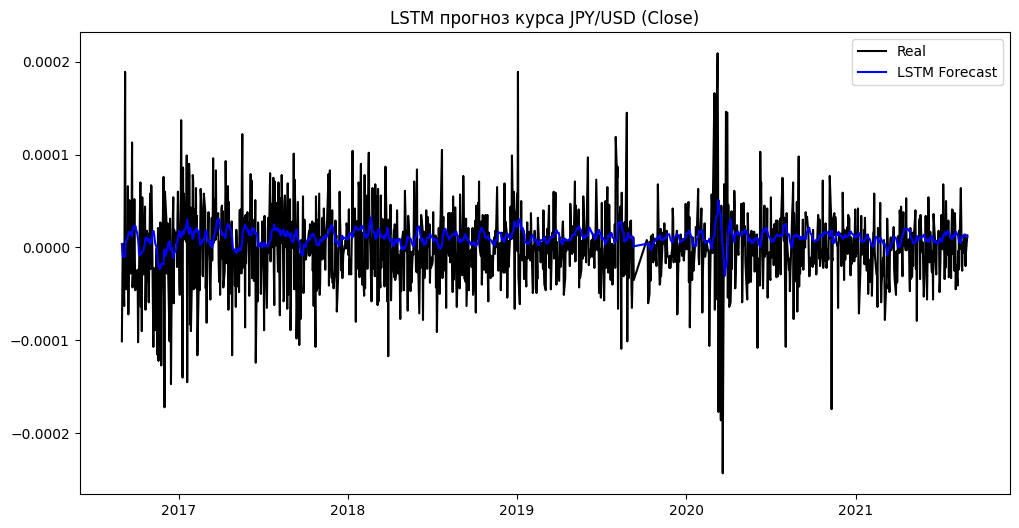

In [ ]:
# LSTM
model_lstm = Sequential([
    LSTM(50, activation="relu", input_shape=(seq_length,1)),
    Dense(1)
])
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.fit(X_train, y_train, epochs=20, verbose=0)

lstm_pred = model_lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

print("LSTM")
print("MAE:", mean_absolute_error(y_test_inv, lstm_pred))

rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_pred))
print("RMSE:", rmse)

plt.figure(figsize=(12,6))
plt.plot(close_diff.index[-len(y_test_inv):], y_test_inv, label="Real", color="black")
plt.plot(close_diff.index[-len(y_test_inv):], lstm_pred, label="LSTM Forecast", color="blue")
plt.legend()
plt.title("LSTM прогноз курса JPY/USD (Close)")
plt.show()



!!!!!!!!!!!!!!!! (2-ой вариант)

In [ ]:
import pandas as pd

In [ ]:
currency_ts = pd.read_csv('extracted_folder/forex.csv')

In [ ]:
currency_ts.head(10)

,slug,date,open,high,low,close,currency
0,GBP/EGP,2001-04-10,5.58090,5.59470,5.59470,5.59470,EGP
1,GBP/EGP,2001-06-04,5.47517,5.49390,5.49390,5.49390,EGP
2,GBP/EGP,2001-08-01,5.67990,5.65430,5.65430,5.65430,EGP
3,GBP/EGP,2002-07-29,7.21700,7.21700,7.21700,7.21700,EGP
4,GBP/EGP,2003-01-02,7.42429,7.38990,7.38990,7.38990,EGP
5,GBP/EGP,2003-04-21,9.29241,9.25045,9.25045,9.25045,EGP
6,GBP/EGP,2004-02-13,11.60700,11.64200,11.52000,11.57800,EGP
7,GBP/EGP,2004-02-16,11.57100,11.62300,11.49900,11.60700,EGP
8,GBP/EGP,2004-02-17,11.60800,11.73900,11.52100,11.66200,EGP
9,GBP/EGP,2004-02-18,11.67700,11.77200,11.63100,11.69100,EGP


In [ ]:
currency_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453035 entries, 0 to 1453034
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   slug      1453035 non-null  object 
 1   date      1453035 non-null  object 
 2   open      1453035 non-null  float64
 3   high      1453035 non-null  float64
 4   low       1453035 non-null  float64
 5   close     1453035 non-null  float64
 6   currency  1453035 non-null  object 
dtypes: float64(4), object(3)
memory usage: 77.6+ MB


In [ ]:
(currency_ts == 0).any()

,0
slug,False
date,False
open,False
high,False
low,False
close,False
currency,False


In [ ]:
# преобразуем дату в datetime
currency_ts["date"] = pd.to_datetime(currency_ts["date"])

In [ ]:
currency_ts.describe()

,date,open,high,low,close
count,1453035,1.453035e+06,1.453035e+06,1.453035e+06,1.453035e+06
mean,2013-02-20 04:39:10.076907776,6.291105e+02,6.334350e+02,6.259781e+02,6.295604e+02
min,1996-10-30 00:00:00,1.000000e-03,4.020000e-03,1.000000e-03,4.000000e-03
25%,2009-01-16 00:00:00,1.732700e+00,1.742100e+00,1.725000e+00,1.732400e+00
50%,2013-04-10 00:00:00,7.884900e+00,7.912100e+00,7.857700e+00,7.886100e+00
75%,2017-06-06 00:00:00,6.429065e+01,6.468050e+01,6.393406e+01,6.422150e+01
max,2021-08-30 00:00:00,2.760431e+06,2.760431e+06,2.760431e+06,2.760431e+06
std,NaN,9.563686e+03,9.577636e+03,9.560176e+03,9.565755e+03


In [ ]:
# делаем дату индексом
currency_ts = currency_ts.set_index("date")

In [ ]:
currency_ts = currency_ts.sort_index()

In [ ]:
currency_ts.head(20)

,slug,open,high,low,close,currency
date,,,,,,
1996-10-30,JPY/USD,0.008744,0.008802,0.008735,0.008758,USD
1996-10-30,USD/JPY,114.370003,114.480003,113.610001,114.180000,JPY
1996-11-01,JPY/USD,0.008811,0.008811,0.008811,0.008811,USD
1996-11-01,USD/JPY,113.500000,113.500000,113.500000,113.500000,JPY
1996-11-04,JPY/USD,0.008828,0.008853,0.008773,0.008781,USD
1996-11-04,USD/JPY,113.279999,113.980003,112.949997,113.879997,JPY
1996-11-05,JPY/USD,0.008794,0.008814,0.008747,0.008753,USD
1996-11-05,USD/JPY,113.709999,114.330002,113.449997,114.250000,JPY
1996-11-06,JPY/USD,0.008754,0.008799,0.008720,0.008776,USD


In [ ]:
currency_ts["slug"].unique()

array(['JPY/USD', 'USD/JPY', 'EUR/SEK', 'EUR/GBP', 'EUR/ZAR', 'EUR/NOK',
       'GBP/EGP', 'USD/PEN', 'USD/EGP', 'USD/CNY', 'USD/IDR', 'USD/ARS',
       'USD/HKD', 'USD/NOK', 'USD/SEK', 'GBP/CZK', 'EUR/JOD', 'EUR/KES',
       'USD/PKR', 'GBP/BND', 'USD/UAH', 'USD/BGN', 'USD/BND', 'GBP/KRW',
       'EUR/BGN', 'GBP/BGN', 'EUR/PLN', 'EUR/BOB', 'USD/BDT', 'EUR/LBP',
       'USD/UYU', 'EUR/COP', 'GBP/TRY', 'GBP/IDR', 'USD/COP', 'EUR/JPY',
       'EUR/CHF', 'GBP/NZD', 'GBP/AUD', 'AUD/GBP', 'CHF/USD', 'USD/CHF',
       'GBP/EUR', 'USD/CAD', 'GBP/CHF', 'INR/USD', 'AUD/DKK', 'USD/INR',
       'INR/THB', 'USD/MWK', 'GBP/CLP', 'GBP/MWK', 'EUR/PHP', 'USD/XOF',
       'USD/MKD', 'USD/CLP', 'EUR/ANG', 'JPY/TWD', 'INR/TWD', 'GBP/USD',
       'USD/TTD', 'USD/XPF', 'JPY/CAD', 'CHF/GBP', 'INR/CNY', 'AUD/MXN',
       'AUD/SEK', 'INR/CAD', 'USD/MDL', 'GBP/TWD', 'CHF/MYR', 'GBP/UGX',
       'GBP/CAD', 'EUR/KRW', 'USD/SOS', 'EUR/BND', 'CHF/SEK', 'CHF/JPY',
       'AUD/HKD', 'CHF/IDR', 'CHF/AUD', 'CHF/CAD', 

In [ ]:
# фильтруем только JPY/USD
jpy_usd = currency_ts[currency_ts["slug"] == "JPY/USD"]

In [ ]:
# убираем лишние колонки
jpy_usd = jpy_usd.drop(columns=["currency", "slug"])

In [ ]:
jpy_usd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6416 entries, 1996-10-30 to 2021-08-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6416 non-null   float64
 1   high    6416 non-null   float64
 2   low     6416 non-null   float64
 3   close   6416 non-null   float64
dtypes: float64(4)
memory usage: 250.6 KB


In [ ]:
# создаём полный диапазон дат от минимальной до максимальной
full_range = pd.date_range(start=jpy_usd.index.min(), end=jpy_usd.index.max(), freq="D")

# сравниваем с индексом
missing_dates = full_range.difference(jpy_usd.index)

print("Пропущенные даты:", missing_dates)

Пропущенные даты: DatetimeIndex(['1996-10-31', '1996-11-02', '1996-11-03', '1996-11-07',
               '1996-11-09', '1996-11-10', '1996-11-14', '1996-11-16',
               '1996-11-17', '1996-11-23',
               ...
               '2021-07-31', '2021-08-01', '2021-08-07', '2021-08-08',
               '2021-08-14', '2021-08-15', '2021-08-21', '2021-08-22',
               '2021-08-28', '2021-08-29'],
              dtype='datetime64[ns]', length=2655, freq=None)


In [ ]:
# определяем день недели (понедельник=0, воскресенье=6)
weekdays = jpy_usd.index.weekday

# считаем выходные (суббота=5, воскресенье=6)
weekend_days = (weekdays >= 5).sum()

# общее количество дней
total_days = len(jpy_usd)

print("Всего дней:", total_days)
print("Выходных дней:", weekend_days)
print("Доля выходных:", weekend_days / total_days * 100, "%")

Всего дней: 6416
Выходных дней: 0
Доля выходных: 0.0 %


In [ ]:
full_range = pd.date_range(start=jpy_usd.index.min(), end=jpy_usd.index.max(), freq="D")
missing_dates = full_range.difference(jpy_usd.index)

# сколько из пропущенных дат — выходные
weekend_missing = (missing_dates.weekday >= 5).sum()
print("Пропущенные выходные:", weekend_missing)

Пропущенные выходные: 2592


In [ ]:
# посмотреть распределение дней недели
jpy_usd.index.weekday.value_counts()

,count
date,
4,1288
0,1283
2,1282
1,1282
3,1281


в выходные отсутствуют значения, что логично, так как биржа не работает

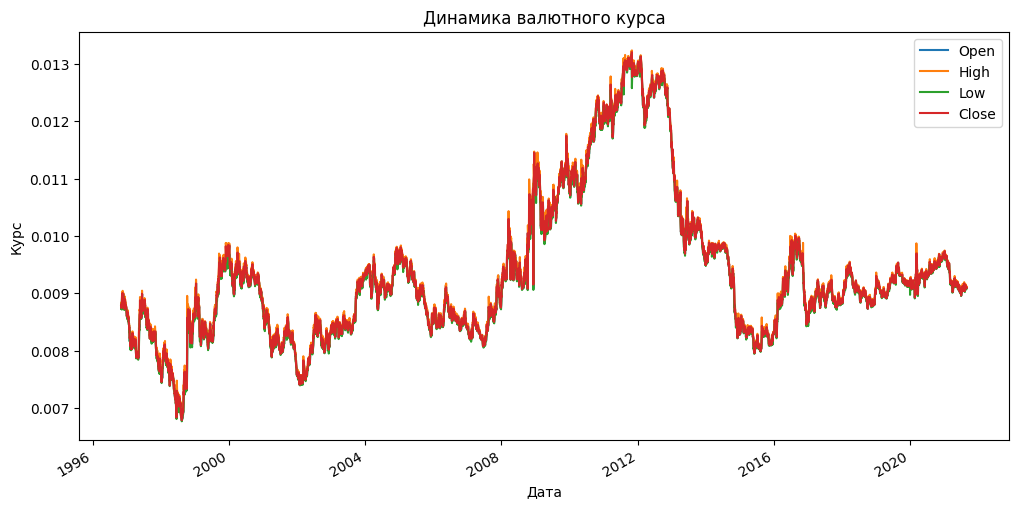

In [ ]:
import matplotlib.pyplot as plt

# Линии для всех колонок
jpy_usd.plot(figsize=(12,6))
plt.title("Динамика валютного курса")
plt.xlabel("Дата")
plt.ylabel("Курс")
plt.legend(["Open", "High", "Low", "Close"])
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(jpy_usd["close"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.7961449414410917
p-value: 0.38237729592201913


In [ ]:
close_diff = jpy_usd["close"].diff().dropna()
from statsmodels.tsa.stattools import adfuller
result = adfuller(close_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -13.34353244713784
p-value: 5.855730023883032e-25


In [ ]:
from sklearn.model_selection import train_test_split

# делим на train/test (80% train, 20% test) - для ARIMA
split_point = int(len(jpy_usd["close"]) * 0.8)
train, test = jpy_usd["close"][:split_point], jpy_usd["close"][split_point:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Подготовка данных для LSTM/GRU
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(close_diff.values.reshape(-1,1))

def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled, seq_length)

# делим на train/test
split_point = int(len(X) * 0.8)
X_train, y_train = X[:split_point], y[:split_point]
X_test, y_test = X[split_point:], y[split_point:]

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.7 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima
auto_model = auto_arima(train, seasonal=False, stepwise=True)
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5132
Model:               SARIMAX(0, 1, 1)   Log Likelihood               41446.056
Date:                Mon, 08 Dec 2025   AIC                         -82888.112
Time:                        13:10:56   BIC                         -82875.026
Sample:                             0   HQIC                        -82883.532
                               - 5132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1689   1.15e-19  -1.47e+18      0.000      -0.169      -0.169
sigma2      5.486e-09   1.84e-11    297.511      0.000    5.45e-09    5.52e-09
Ljung-Box (L1) (Q):                   0.05   Jarque-

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA
MAE: 0.0007903406016520207
RMSE: 0.000833375126416153


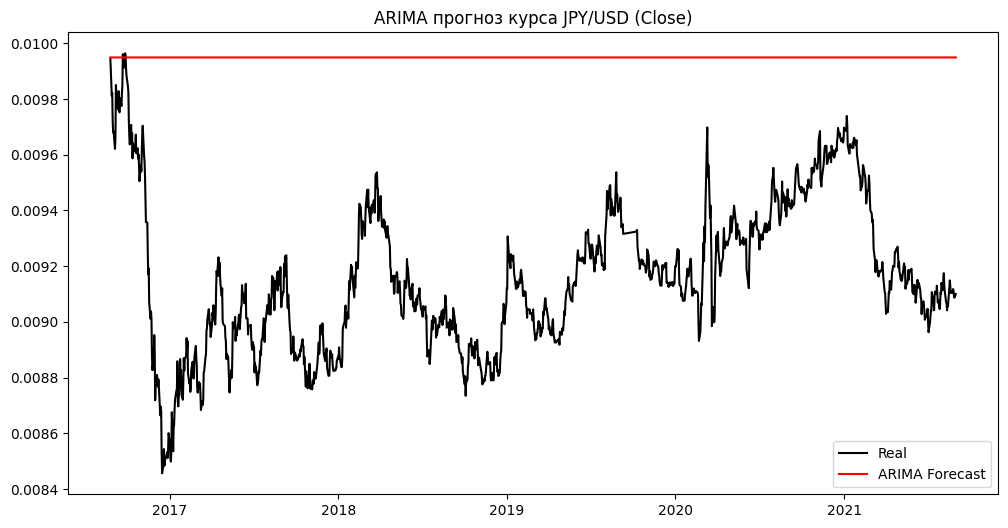

In [ ]:
# ARIMA
model_arima = ARIMA(train, order=(0,1,1))  # d=1
arima_fit = model_arima.fit()
arima_pred = arima_fit.predict(start=len(train), end=len(train)+len(test)-1)

print("ARIMA")
print("MAE:", mean_absolute_error(test, arima_pred))
print("RMSE:", np.sqrt(mean_squared_error(test, arima_pred)))

plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Real", color="black")
plt.plot(test.index, arima_pred, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("ARIMA прогноз курса JPY/USD (Close)")
plt.show()

In [ ]:
# GRU
model_gru = Sequential([
    GRU(50, activation="relu", input_shape=(seq_length,1)),
    Dense(1)
])
model_gru.compile(optimizer="adam", loss="mse")
model_gru.fit(X_train, y_train, epochs=20, verbose=0)

gru_pred = model_gru.predict(X_test)
gru_pred = scaler.inverse_transform(gru_pred)

print("GRU")
print("MAE:", mean_absolute_error(y_test_inv, gru_pred))
print("RMSE:", mean_squared_error(y_test_inv, gru_pred, squared=False))

plt.figure(figsize=(12,6))
plt.plot(close_diff.index[-len(y_test_inv):], y_test_inv, label="Real", color="black")
plt.plot(close_diff.index[-len(y_test_inv):], gru_pred, label="GRU Forecast", color="green")
plt.legend()
plt.title("GRU прогноз курса JPY/USD (Close)")
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
GRU


NameError: name 'y_test_inv' is not defined

In [ ]:
# LSTM
model_lstm = Sequential([
    LSTM(50, activation="relu", input_shape=(seq_length,1)),
    Dense(1)
])
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.fit(X_train, y_train, epochs=20, verbose=0)

lstm_pred = model_lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

print("LSTM")
print("MAE:", mean_absolute_error(y_test_inv, lstm_pred))
print("RMSE:", mean_squared_error(y_test_inv, lstm_pred, squared=False))

plt.figure(figsize=(12,6))
plt.plot(series.index[-len(y_test_inv):], y_test_inv, label="Real", color="black")
plt.plot(series.index[-len(y_test_inv):], lstm_pred, label="LSTM Forecast", color="blue")
plt.legend()
plt.title("LSTM прогноз курса JPY/USD (Close)")
plt.show()

In [ ]:
# Конечный вариант

In [ ]:
# Генерация лагов
for lag in range(1, max_lag + 1):
    data[f'lag_{lag}'] = data['close'].shift(lag)

In [ ]:
horizons = [7, 14, 21, 28]

In [ ]:
# Для каждого горизонта создаем свой таргет (значение close через h шагов)
for h in horizons:
    data[f'target_h{h}'] = data['close'].shift(-h)

In [ ]:
data_model = data.dropna().reset_index(drop=True)

data_model.head()

In [ ]:
n = len(data_model)
split_idx = int(n * 0.8)

train_data = data_model.iloc[:split_idx]
test_data  = data_model.iloc[split_idx:]

# Список признаков (все lag_*)
feature_cols = [c for c in data_model.columns if c.startswith('lag_')]

len(train_data), len(test_data), feature_cols[:5]

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
test_data.index

In [ ]:
final_rows = []

for h in horizons:
    target_col = f"target_h{h}"

    # Последняя строка train (она и есть точка, откуда предсказываем)
    X_last = train_data.iloc[[-1]][feature_cols]
    last_train_index = train_data.index[-1]

    real_value = data_model.loc[last_train_index + h, "close"]

    # XGBoost
    xgb = XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(train_data[feature_cols], train_data[target_col])
    pred_xgb = float(xgb.predict(X_last)[0])

    final_rows.append({
        "Горизонт_дней": h,
        "Модель": "XGBoost",
        "Прогноз": round(pred_xgb, 6),
        "Реальное": round(real_value, 6),
        "Ошибка": round(abs(real_value - pred_xgb), 6)
    })

    # LightGBM
    lgbm = LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    )
    lgbm.fit(train_data[feature_cols], train_data[target_col])
    pred_lgbm = float(lgbm.predict(X_last)[0])

    final_rows.append({
        "Горизонт_дней": h,
        "Модель": "LightGBM",
        "Прогноз": round(pred_lgbm, 6),
        "Реальное": round(real_value, 6),
        "Ошибка": round(abs(real_value - pred_lgbm), 6)
    })

results_table = pd.DataFrame(final_rows)
results_table